In [1]:
! pip3 install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.4 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(12,7)})

import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
po.init_notebook_mode(connected=True)

from mpl_toolkits import mplot3d

#### Here, we are using Online Retail Data containing transactions from 01/12/2010 and 09/12/2011
http://archive.ics.uci.edu/ml/datasets/online+retail

In [3]:
Rtl_data = pd.read_csv("../input/online-retailcsv/Online Retail.csv", encoding = 'unicode_escape',index_col=False)
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
Rtl_data.shape

(541909, 8)

#### Customer Distribution by country

In [5]:
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


> As we can see in above table that the customers are distributed differently in different contries. So, for better Visualization purpose we can perform analysis separately for each country.
**Now, we will Keep only United Kingdom data for further analysis.**

In [6]:
Rtl_data = Rtl_data.query("Country=='United Kingdom'").reset_index(drop=True)

#### Data Cleaning Steps:

In [7]:
#missing values in the dataset
Rtl_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [8]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

In [9]:
#Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()

-80995

In [10]:
#Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [11]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [12]:
#Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [13]:
Rtl_data.shape

(354345, 8)

#### Feature Extraction Steps:

In [14]:
#Adding new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

In [15]:
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


#  **RFM Modelling**


* Recency(R) = Latest Date - Last Inovice Data 
* Frequency(F) = count of invoice no. of transaction(s)
* Monetary(M) = Sum of Total Amount for each customer

Note: The lower value of R is better. And the higher values of F & M are better. 

In [16]:
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,22,103,4196.01
2,12748.0,4,4596,33719.73
3,12749.0,22,199,4090.88
4,12820.0,44,59,942.34


In [17]:
#Condition For better results : The Customer must have visited at least three times.
RFMScores = RFMScores.loc[(RFMScores["Frequency"] >= 3)]
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12747.0,22,103,4196.01
1,12748.0,4,4596,33719.73
2,12749.0,22,199,4090.88
3,12820.0,44,59,942.34
4,12821.0,95,6,92.72


> #####  Recency Descriptive Statistics 

In [18]:
RFMScores.Recency.describe()

count    3799.000000
mean      101.072914
std       111.701186
min        -1.000000
25%        21.000000
50%        59.000000
75%       155.000000
max       696.000000
Name: Recency, dtype: float64

Text(0.5, 1.0, 'Recency Distribution Curve')

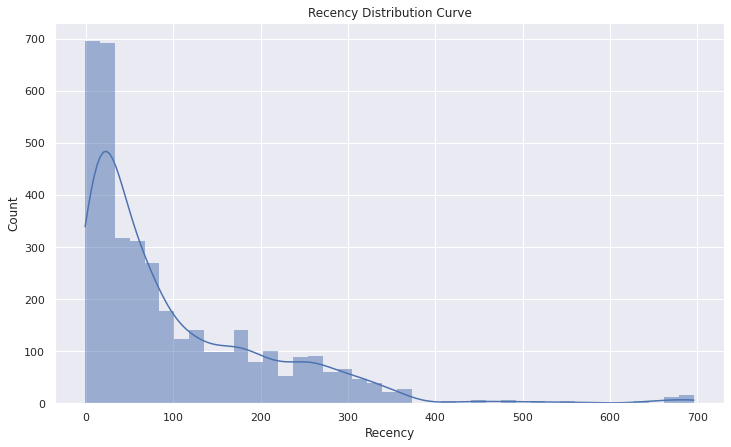

In [19]:
x = RFMScores['Recency']
sns.histplot(x, label="100% Equities", kde=True, linewidth=0)
plt.title("Recency Distribution Curve")

> #####  Frequency Descriptive Statistics 

In [20]:
RFMScores.Frequency.describe()

count    3799.000000
mean       93.227691
std       220.672934
min         3.000000
25%        18.000000
50%        43.000000
75%       102.000000
max      7847.000000
Name: Frequency, dtype: float64

Text(0.5, 1.0, 'Frequency Distribution Curve')

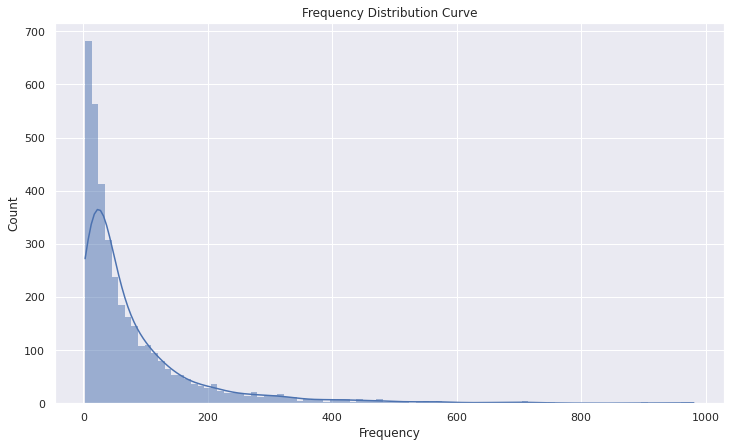

In [21]:
x = RFMScores.query('Frequency < 1000')['Frequency']
sns.histplot(x, label="100% Equities", kde=True, linewidth=0)
plt.title("Frequency Distribution Curve")

> #####  Monetary Descriptive Statistics 

In [22]:
RFMScores.Monetary.describe()

count      3799.000000
mean       1892.897056
std        7496.338937
min          13.300000
25%         308.530000
50%         669.110000
75%        1619.210000
max      259657.300000
Name: Monetary, dtype: float64

Text(0.5, 1.0, 'Moetary Distribution Curve')

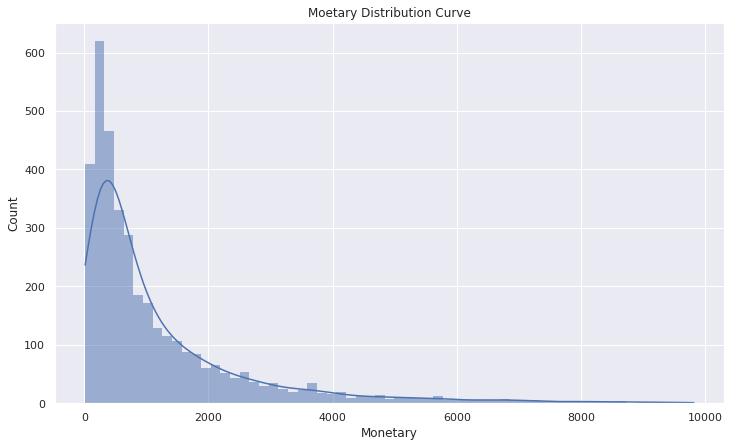

In [23]:
x = RFMScores.query('Monetary < 10000')['Monetary']
sns.histplot(x, label="100% Equities", kde=True, linewidth=0)
plt.title("Moetary Distribution Curve")

Now, we will create **segments for R,F and M** using quantile values.

In [24]:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles 

{'Recency': {0.25: 21.0, 0.5: 59.0, 0.75: 155.0},
 'Frequency': {0.25: 18.0, 0.5: 43.0, 0.75: 102.0},
 'Monetary': {0.25: 308.53, 0.5: 669.1099999999999, 0.75: 1619.21}}

In [25]:
#Function to create R segments, where '1' represents lower values of R
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [26]:
#Function to create F and M segments, where '1' represents higher values of both F and M
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [27]:
#Calculate and Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12747.0,22,103,4196.01,2,1,1
12748.0,4,4596,33719.73,1,1,1
12749.0,22,199,4090.88,2,1,1
12820.0,44,59,942.34,2,2,2
12821.0,95,6,92.72,3,4,4


In [28]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12747.0,22,103,4196.01,2,1,1,211,4
12748.0,4,4596,33719.73,1,1,1,111,3
12749.0,22,199,4090.88,2,1,1,211,4
12820.0,44,59,942.34,2,2,2,222,6
12821.0,95,6,92.72,3,4,4,344,11


Note: In Above Table, the **lower values** of RFMScore represents the **most loyal customers**.

In [29]:
#Assigning Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values

#Here qcut is used for dividing data in equal size beans.
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12747.0,22,103,4196.01,2,1,1,211,4,Platinum
1,12748.0,4,4596,33719.73,1,1,1,111,3,Platinum
2,12749.0,22,199,4090.88,2,1,1,211,4,Platinum
3,12820.0,44,59,942.34,2,2,2,222,6,Gold
4,12821.0,95,6,92.72,3,4,4,344,11,Bronze


In [30]:
#Validating the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,11,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,2,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,5,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,11,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,11,5111,65164.79,1,1,1,111,3,Platinum
5,15311.0,-1,2379,60767.90,1,1,1,111,3,Platinum
6,13089.0,5,1818,58825.83,1,1,1,111,3,Platinum
7,15061.0,4,403,54534.14,1,1,1,111,3,Platinum
8,14088.0,10,589,50491.81,1,1,1,111,3,Platinum
9,17841.0,-1,7847,40991.57,1,1,1,111,3,Platinum


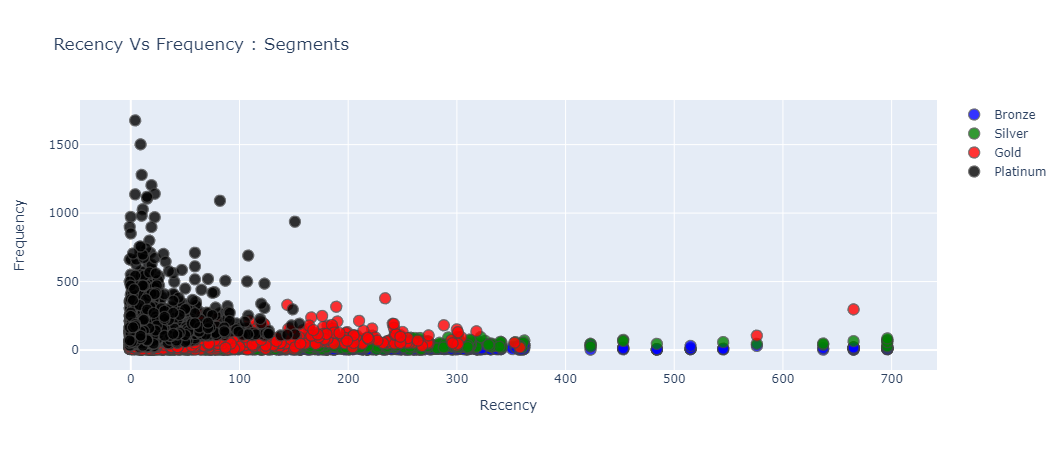

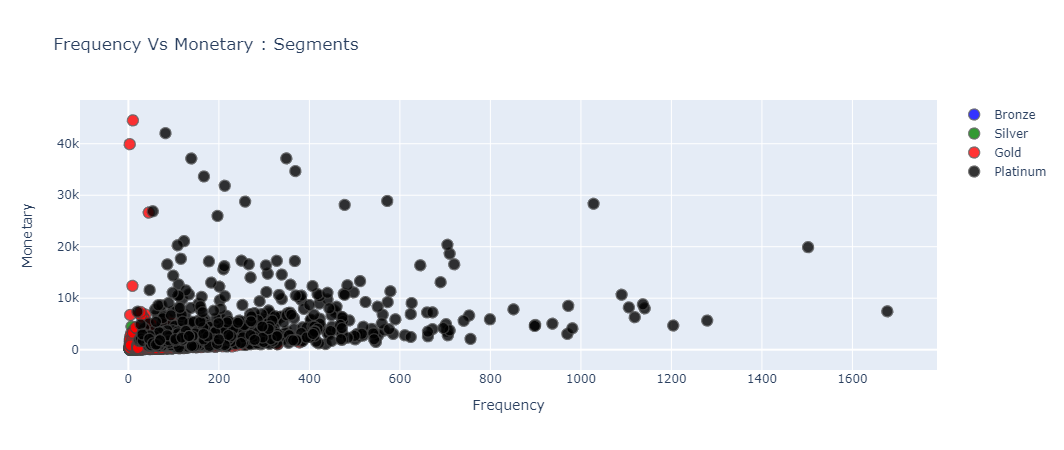

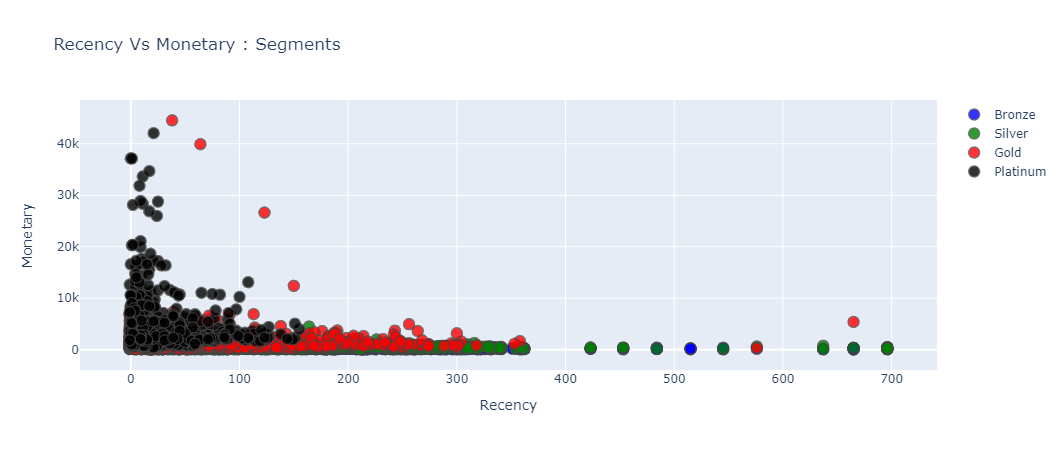

In [31]:
# Function for making Comparison plots
def Comp_plot(field1,field2):
    graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")
    
    plot_data = [
        gobj.Scatter(
            x=graph.query("RFM_Loyalty_Level == 'Bronze'")[field1],
            y=graph.query("RFM_Loyalty_Level == 'Bronze'")[field2],
            mode='markers',
            name='Bronze',
            marker= dict(size= 11,
                line= dict(width=1),
                color= 'blue',
                opacity= 0.8
               )
        ),
            gobj.Scatter(
            x=graph.query("RFM_Loyalty_Level == 'Silver'")[field1],
            y=graph.query("RFM_Loyalty_Level == 'Silver'")[field2],
            mode='markers',
            name='Silver',
            marker= dict(size= 11,
                line= dict(width=1),
                color= 'green',
                opacity= 0.8
               )
        ),
            gobj.Scatter(
            x=graph.query("RFM_Loyalty_Level == 'Gold'")[field1],
            y=graph.query("RFM_Loyalty_Level == 'Gold'")[field2],
            mode='markers',
            name='Gold',
            marker= dict(size= 11,
                line= dict(width=1),
                color= 'red',
                opacity= 0.8
               )
        ),
        gobj.Scatter(
            x=graph.query("RFM_Loyalty_Level == 'Platinum'")[field1],
            y=graph.query("RFM_Loyalty_Level == 'Platinum'")[field2],
            mode='markers',
            name='Platinum',
            marker= dict(size= 11,
                line= dict(width=1),
                color= 'black',
                opacity= 0.8
               )
        ),
    ]

    plot_layout = gobj.Layout(
            xaxis= {'title': field1},
            yaxis= {'title': field2},
            title='{} Vs {} : Segments'.format(field1,field2)
        )
    
    fig = gobj.Figure(data=plot_data, layout=plot_layout)
    print("\n")
    po.iplot(fig)

    
#Recency Vs Frequency
Comp_plot('Recency','Frequency')    
    
#Frequency Vs Monetary
Comp_plot('Frequency','Monetary')

#Recency Vs Monetary
Comp_plot('Recency','Monetary')

In [32]:
RFMScores.tail(25)

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
CustomerID,,,,,,,,,
18249.0,17,8,95.34,1,4,4,144,9,Silver
18250.0,310,21,349.27,4,3,3,433,10,Silver
18251.0,87,16,4314.72,3,4,1,341,8,Gold
18252.0,50,98,526.67,2,2,3,223,7,Gold
18255.0,30,6,103.30,2,4,4,244,10,Silver
18257.0,39,118,2337.63,2,1,1,211,4,Platinum
18259.0,24,42,2338.60,2,3,1,231,6,Gold
18260.0,99,134,2643.20,3,1,1,311,5,Platinum
18261.0,43,21,324.24,2,3,3,233,8,Gold


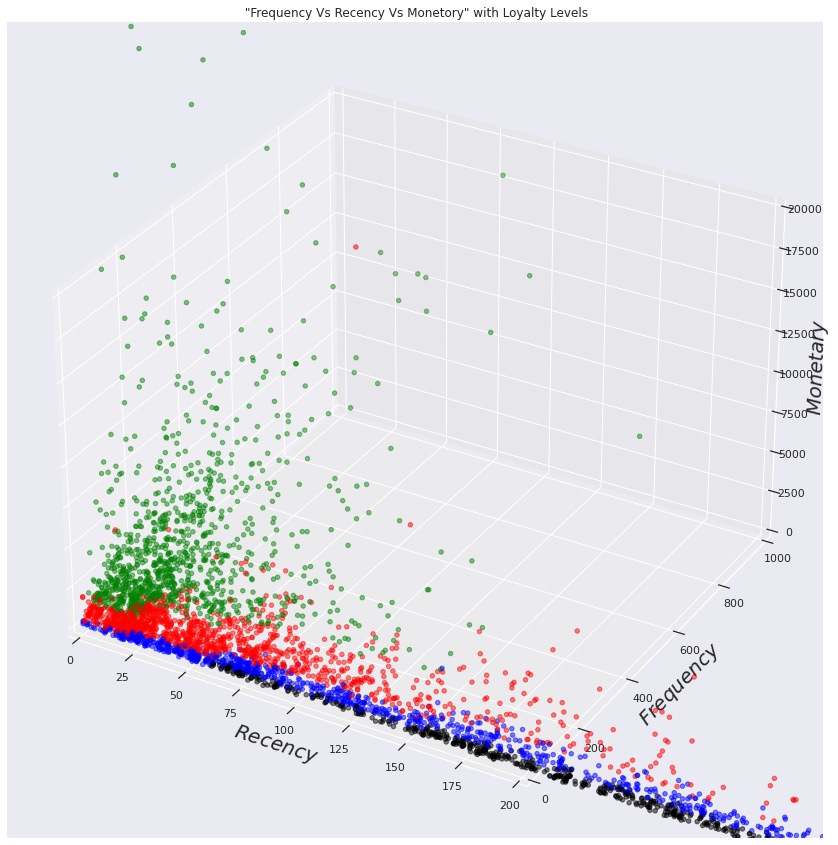

In [33]:
#For ploting purpose we are assigning different colors to different loyalty levels.
color_dic={ "Platinum":"green", "Gold":"red", "Silver":"blue", "Bronze":"black" }

def Loyalty_fun(x):
    if (x>=3) & (x<=5) :
        return color_dic["Platinum"]
    elif (x>=6) & (x<=8) :
        return color_dic["Gold"]
    elif (x>=9) & (x<=10) :
        return color_dic["Silver"]
    elif (x>=11) & (x<=12) :
        return color_dic["Bronze"]
    
# Colors for Loyalty_Level
RFMScores['Color'] = RFMScores['RFMScore'].map(Loyalty_fun)
             
# Creating p
fig = plt.figure(figsize = (20, 15))
ax = plt.axes(projection ="3d")
ax.scatter3D(RFMScores['Recency'],RFMScores['Frequency'],RFMScores['Monetary'], c=RFMScores['Color'])
plt.title("3D scatter plot")
ax.set_xlabel('$Recency$', fontsize=20)
ax.set_ylabel('$Frequency$', fontsize=20)
ax.set_zlabel('$Monetary$', fontsize=20)
ax.set_xlim3d(0,200)
ax.set_ylim3d(0,1000)
ax.set_zlim3d(0,20000)
  
plt.title(" \"Frequency Vs Recency Vs Monetory\" with Loyalty Levels")
plt.show()

# **K-Means Clustering Model**

#### Feature Scaling Steps:

In [34]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
    
#Applying function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]
RFMScores

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Color
CustomerID,,,,,,,,,,
12747.0,22,103,4196.01,2,1,1,211,4,Platinum,green
12748.0,4,4596,33719.73,1,1,1,111,3,Platinum,green
12749.0,22,199,4090.88,2,1,1,211,4,Platinum,green
12820.0,44,59,942.34,2,2,2,222,6,Gold,red
12821.0,95,6,92.72,3,4,4,344,11,Bronze,black
...,...,...,...,...,...,...,...,...,...,...
18280.0,159,10,180.60,4,4,4,444,12,Bronze,black
18281.0,3,7,80.82,1,4,4,144,9,Silver,blue
18282.0,215,12,178.05,4,4,4,444,12,Bronze,black


> **Data Log Transformation**

In [35]:
#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
Log_Tfd_Data

,Recency,Frequency,Monetary
CustomerID,,,
12747.0,3.091,4.635,8.342
12748.0,1.386,8.433,10.426
12749.0,3.091,5.293,8.317
12820.0,3.784,4.078,6.848
12821.0,4.554,1.792,4.530
...,...,...,...
18280.0,5.069,2.303,5.196
18281.0,1.099,1.946,4.392
18282.0,5.371,2.485,5.182


Text(0.5, 1.0, 'Recency Distribution after Log Transformation')

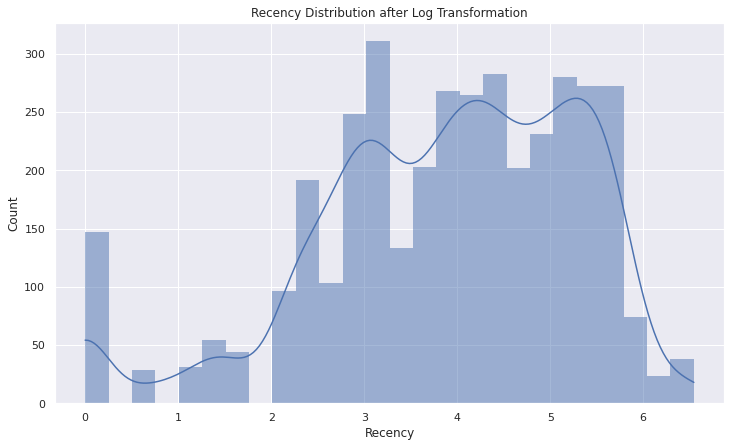

In [36]:
Recency_Plot_data = Log_Tfd_Data['Recency']
sns.histplot(Recency_Plot_data, label="100% Equities", kde=True, linewidth=0)
plt.title("Recency Distribution after Log Transformation")

Text(0.5, 1.0, 'Frequency Distribution after Log Transformation')

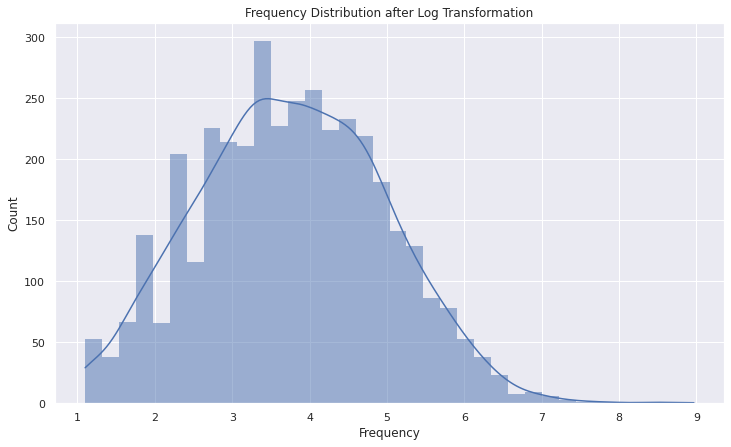

In [37]:
Frequency_Plot_data = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
sns.histplot(Frequency_Plot_data, label="100% Equities", kde=True, linewidth=0)
plt.title("Frequency Distribution after Log Transformation")

Text(0.5, 1.0, 'Monetary Distribution after Log Transformation')

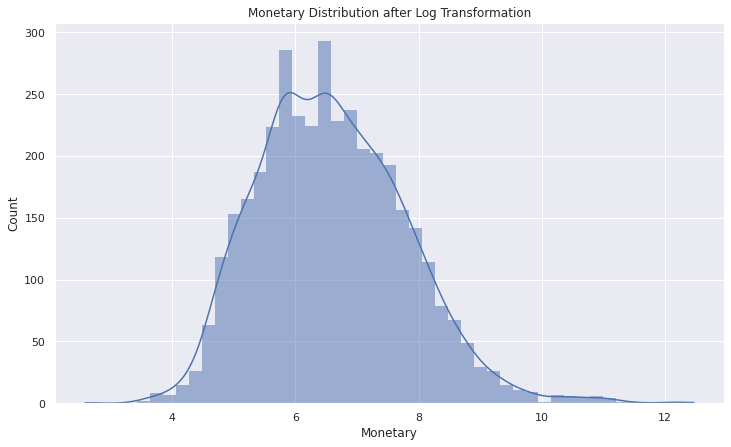

In [38]:
Monetary_Plot_data = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
sns.histplot(Monetary_Plot_data, label="100% Equities", kde=True, linewidth=0)
plt.title("Monetary Distribution after Log Transformation")

> **Data Standardization**

In [39]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)
Scaled_Data.describe()

,Recency,Frequency,Monetary
count,3.799000e+03,3.799000e+03,3.799000e+03
mean,-6.265644e-17,-1.122205e-17,4.937702e-16
std,1.000132e+00,1.000132e+00,1.000132e+00
min,-2.721938e+00,-2.201959e+00,-3.323839e+00
25%,-5.892288e-01,-7.252426e-01,-7.154235e-01
50%,1.342816e-01,-7.084933e-03,-7.327550e-02
75%,8.101650e-01,7.053011e-01,6.597190e-01
max,1.862162e+00,4.286195e+00,4.872260e+00


In [40]:
Scaled_Data

,Recency,Frequency,Monetary
CustomerID,,,
12747.0,-0.557011,0.713546,1.449959
12748.0,-1.751188,3.845077,3.178947
12749.0,-0.557011,1.256081,1.429218
12820.0,-0.071635,0.254288,0.210464
12821.0,0.467671,-1.630567,-1.712661
...,...,...,...
18280.0,0.828375,-1.209236,-1.160115
18281.0,-1.952202,-1.503590,-1.827153
18282.0,1.039895,-1.059174,-1.171730


Finding Optimal number of clusters (**K's value**) using **Elbow Method**

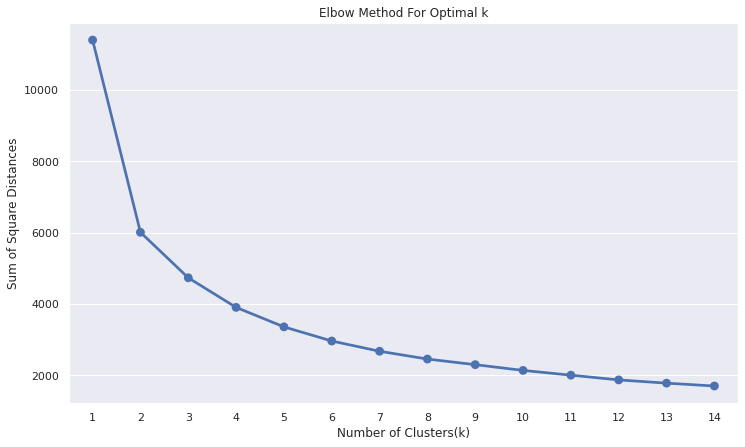

In [41]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [42]:
#Building the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000, random_state=25)
KMean_clust.fit(Scaled_Data)

#Clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Color,Cluster
CustomerID,,,,,,,,,,,
12747.0,22,103,4196.01,2,1,1,211,4,Platinum,green,2
12748.0,4,4596,33719.73,1,1,1,111,3,Platinum,green,2
12749.0,22,199,4090.88,2,1,1,211,4,Platinum,green,2
12820.0,44,59,942.34,2,2,2,222,6,Gold,red,0
12821.0,95,6,92.72,3,4,4,344,11,Bronze,black,1
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,159,10,180.60,4,4,4,444,12,Bronze,black,1
18281.0,3,7,80.82,1,4,4,144,9,Silver,blue,1
18282.0,215,12,178.05,4,4,4,444,12,Bronze,black,1


Silhouette Analysis

silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)

In [43]:
from sklearn.metrics import silhouette_score

for num_cluster in [2,3,4,5,6]:
    KMean_clust = KMeans(n_clusters= num_cluster, init= 'k-means++', max_iter= 1000, random_state=25)
    KMean_clust.fit(Scaled_Data)
    
    cluster_labels = KMean_clust.labels_
    silhouette_avg= silhouette_score(Scaled_Data, cluster_labels)
    
    print("For n_clusters={0}, the silhouette score is {1}".format(num_cluster, silhouette_avg))

For n_clusters=2, the silhouette score is 0.40260980706276506
For n_clusters=3, the silhouette score is 0.30044259327436973
For n_clusters=4, the silhouette score is 0.30624761133435
For n_clusters=5, the silhouette score is 0.2733386642951956
For n_clusters=6, the silhouette score is 0.27984095252774455


> By comparing both Elbow method and Silhouette score, the optimal value of K will be 3.

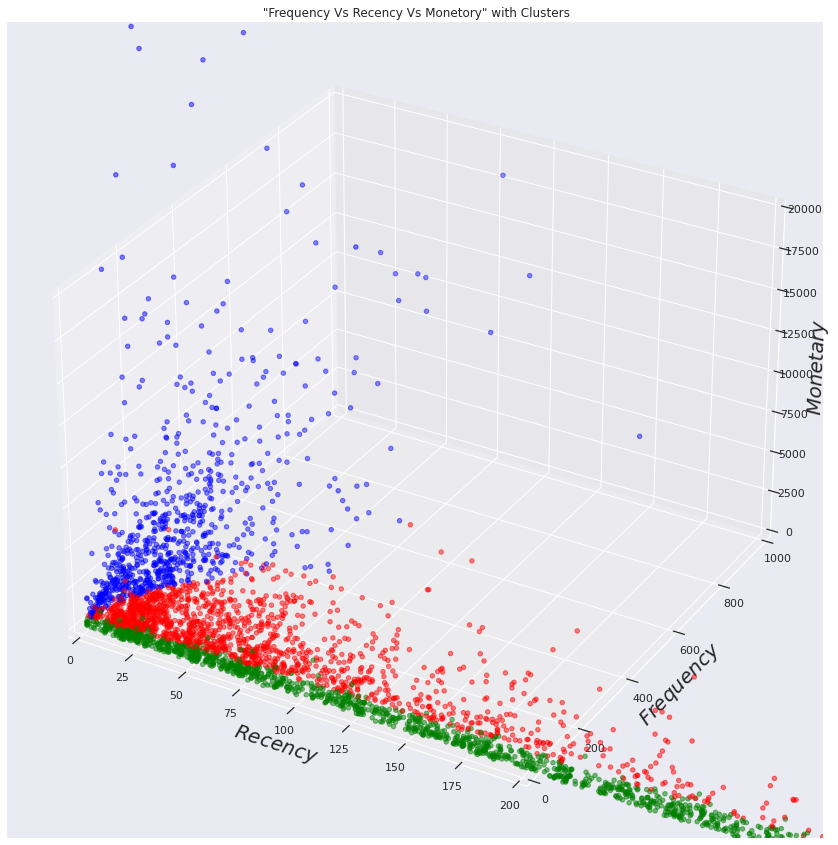

In [44]:
#Cluters Scatter Plot
fig = plt.figure(figsize = (20, 15))
ax = plt.axes(projection ="3d")

# Assigning colors according to clusters for clusters
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])

# Creating plot
ax.scatter3D(RFMScores['Recency'],RFMScores['Frequency'],RFMScores['Monetary'], c=RFMScores['Color'])
plt.title("3D scatter plot")
ax.set_xlabel('$Recency$', fontsize=20)
ax.set_ylabel('$Frequency$', fontsize=20)
ax.set_zlabel('$Monetary$', fontsize=20)
ax.set_xlim3d(0,200)
ax.set_ylim3d(0,1000)
ax.set_zlim3d(0,20000)

# show plot
plt.title(" \"Frequency Vs Recency Vs Monetory\" with Clusters")
plt.show()

> **Distribution of Recency, Frequency and Monetary in each cluster:**

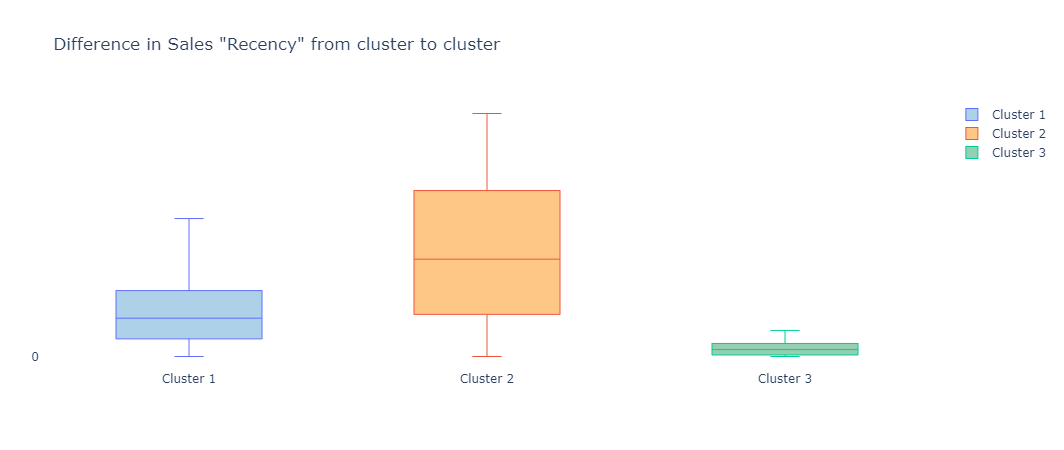

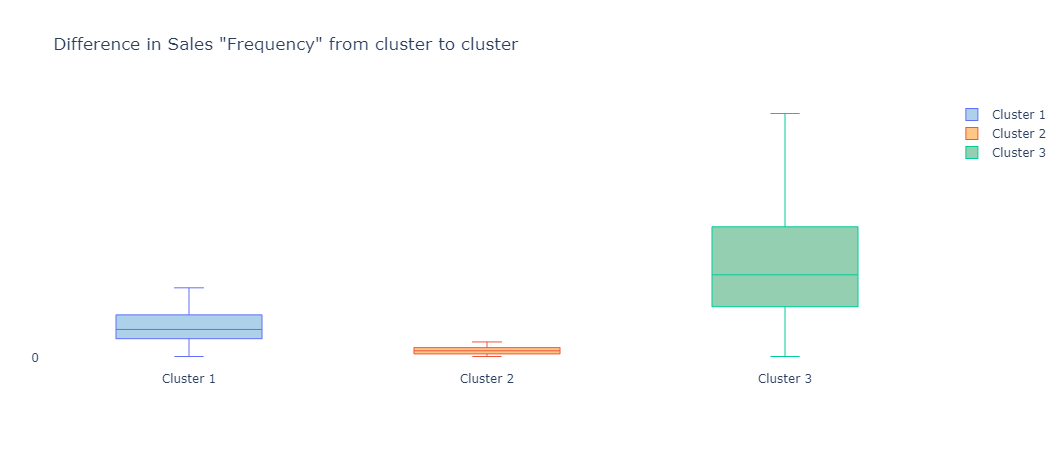

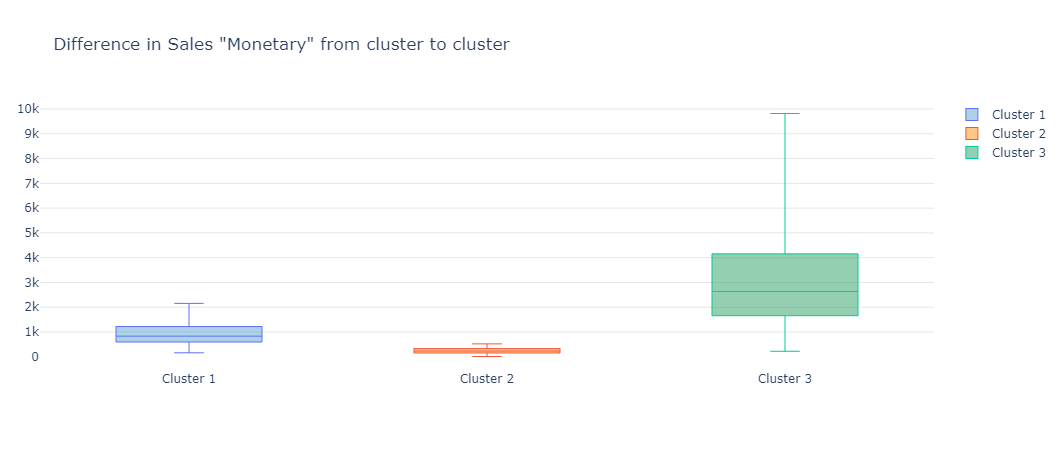

In [45]:
def Box_plotting(field_to_plot):
    cutoff_quantile = 90
    x_data = ['Cluster 1','Cluster 2','Cluster 3']
    y0 = RFMScores[RFMScores['Cluster']==0][field_to_plot].values
    y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
    y1 = RFMScores[RFMScores['Cluster']==1][field_to_plot].values
    y1 = y1[y1<np.percentile(y1, cutoff_quantile)]
    y2 = RFMScores[RFMScores['Cluster']==2][field_to_plot].values
    y2 = y2[y2<np.percentile(y2, cutoff_quantile)]

    y_data = [y0,y1,y2]

    colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
    traces = []

    for xd, yd, cls in zip(x_data, y_data, colors):
            traces.append(gobj.Box(
                y=yd,
                name=xd,
                boxpoints=False,
                jitter=0.5,
                whiskerwidth=0.2,
                fillcolor=cls,
                marker=dict(
                    size=2,
                ),
                line=dict(width=1),
            ))

    layout = gobj.Layout(
        title='Difference in Sales \"{}\" from cluster to cluster'.format(field_to_plot),
        yaxis=dict(
            autorange=True,
            showgrid=True,
            zeroline=True,
            dtick=1000,
            gridcolor='black',
            gridwidth=0.1,
            zerolinecolor='rgb(255, 255, 255)',
            zerolinewidth=2,
        ),
        margin=dict(
            l=40,
            r=30,
            b=80,
            t=100,
        ),
        plot_bgcolor='white',
        showlegend=True
    )
    fig = gobj.Figure(data=traces, layout=layout)
    po.offline.iplot(fig)
    
Box_plotting("Recency")
print("\n")
Box_plotting("Frequency")
print("\n")
Box_plotting("Monetary")

> #### Now we will see the distribution of different type of customers in each cluster.  

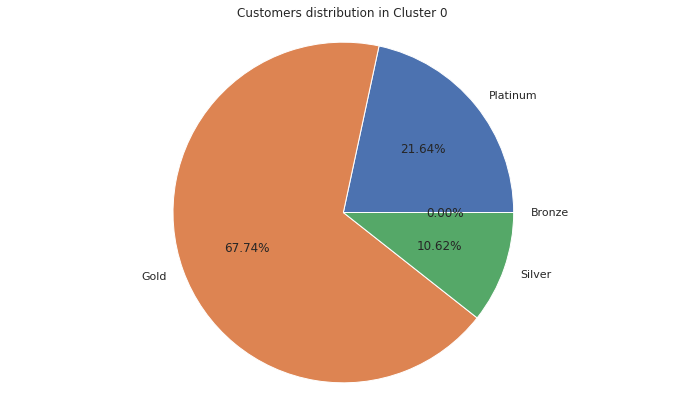

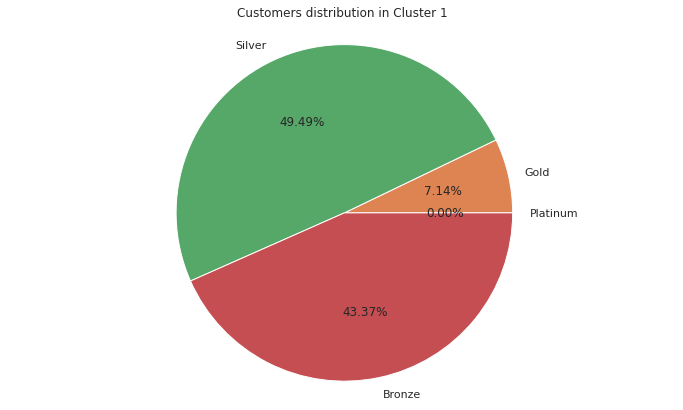

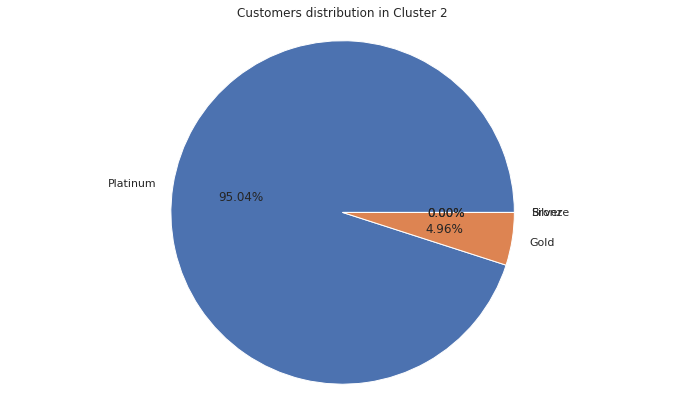

In [46]:
# Separating RFMScores in clusters
clust1 = RFMScores[(RFMScores['Cluster']==0)]
c1=clust1['RFM_Loyalty_Level'].value_counts()
clust2 = RFMScores[(RFMScores['Cluster']==1)]
c2=clust2['RFM_Loyalty_Level'].value_counts()
clust3 = RFMScores[(RFMScores['Cluster']==2)]
c3=clust3['RFM_Loyalty_Level'].value_counts()

def Pie_num(s, x):
    return s[x]

Customer_labels = ['Platinum', 'Gold', 'Silver', 'Bronze']
print("\n")

#For cluster no.1
sizes1=[Pie_num(c1,Customer_labels[i]) for i in range(4)]
fig, ax = plt.subplots()
ax.pie(sizes1, labels=Customer_labels, autopct='%1.2f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Customers distribution in Cluster 0')
plt.show()
print("\n")

#For cluster no.2
sizes2=[Pie_num(c2,Customer_labels[i]) for i in range(4)]
fig, ax = plt.subplots()
ax.pie(sizes2, labels=Customer_labels, autopct='%1.2f%%')
ax.axis('equal')  
ax.set_title('Customers distribution in Cluster 1')
plt.show()
print("\n")

#For cluster no.3 
sizes3=[Pie_num(c3,Customer_labels[i]) for i in range(4)]
fig, ax = plt.subplots()
ax.pie(sizes3, labels=Customer_labels, autopct='%1.2f%%')
ax.axis('equal')
ax.set_title('Customers distribution in Cluster 2')
plt.show()

### **Demo Application: Customer Classifier**

In [47]:
# Using RFM Model
def pred_cust(data):
    R = data['Recency'].apply(RScoring, args=('Recency',quantiles,))[0]
    F = data['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))[0]
    M = data['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))[0]
    x = R + F + M
    # By observing the data from RFM model
    if (x>=3) & (x<=5) :
        return "Platinum"
    elif (x>=6) & (x<=8) :
        return "Gold"
    elif (x>=9) & (x<=10) :
        return "Silver"
    elif (x>=11) & (x<=12) :
        return "Bronze"
    
def main():
    data=pd.DataFrame({'Recency':None , 'Frequency':None, 'Monetary':None},index=[0])
    print("\nE-MART CRM Portal \n To check the Customer's Membership Category please enter the below details:\n")
    print("Please enter Customer's Recency Score:")
    data['Recency']=int(input())
    print("Please enter Customer's Frequency Score:")
    data['Frequency']=int(input())
    print("Please enter Customer's Monetary Score:")
    data['Monetary']=int(input())
    print("************** Processing Data ****************\n")
    print("This customer is {} category customer.".format(pred_cust(data)) )   
    
main()    


E-MART CRM Portal 
 To check the Customer's Membership Category please enter the below details:

Please enter Customer's Recency Score:


 50


Please enter Customer's Frequency Score:


 5


Please enter Customer's Monetary Score:


 5000


************** Processing Data ****************

This customer is Gold category customer.


In [48]:
# Using Decision Tree Classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Pre_data=RFMScores[["Recency","Frequency","Monetary","Cluster"]]

# Seperating the data into dependent and independent variables
X = Pre_data.iloc[:, :-1].values
y = Pre_data.iloc[:, -1].values

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Decision Tree
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


def main():
    data=pd.DataFrame({'Recency':None , 'Frequency':None, 'Monetary':None},index=[0])
    print("\nE-MART CRM Portal \n To check the Customer's Membership Category please enter the below details:\n")
    print("Please enter Customer's Recency Score:")
    data['Recency']=int(input())
    print("Please enter Customer's Frequency Score:")
    data['Frequency']=int(input())
    print("Please enter Customer's Monetary Score:")
    data['Monetary']=int(input())
    print("************** Processing Data ****************\n")
    pred=classifier.predict(data)
    print("The Cluster of this Customer is :- ")
    print(pred)

    
main()
# Accuracy score
print('accuracy is',accuracy_score(y_pred,y_test))


E-MART CRM Portal 
 To check the Customer's Membership Category please enter the below details:

Please enter Customer's Recency Score:


 50


Please enter Customer's Frequency Score:


 5


Please enter Customer's Monetary Score:


 5000


************** Processing Data ****************

The Cluster of this Customer is :- 
[0]
accuracy is 0.9578947368421052


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

